In [1]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)

In [2]:


import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from skimage import filters, transform, morphology, registration
from tifffile import imsave

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler
import time
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, stackViewer
from spikecounter import utils
import seaborn as sns

biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [3]:
x = 60

In [ ]:
rootdir = "/n/holyscratch01/cohen_lab/bjia"
datadirs = [os.path.join(rootdir, d) for d in ["20211018_25x_gcamp_focus", "20220203_gcamp_site_of_initiation",\
                                               "20220505_25x_gcamp_focus"]]
subfolder = "corrected"
data = pd.concat([pd.read_csv(os.path.join(d, "analysis", subfolder, "wavefront_data_full.csv")) for d in datadirs])
data.loc[np.isnan(data["date"]),"date"] = 0
data["date"] = data["date"].astype(int).astype(str)

In [ ]:
q = [pd.read_csv(os.path.join(d, "analysis", subfolder, "wavefront_data_full.csv")) for d in datadirs]

20211018 - 094259E4_gcamp_fast shows beat-to-beat variability of LOI.

In [14]:
exclude_files = ["110549E1_gcamp_fast", "091330E6_gcamp_fast", "092921E6_gcamp_fast",\
                 "095023E6_gcamp_fast", "100456E6_gcamp_fast", "101658E6_gcamp_fast",\
                 "103229E6_gcamp_fast", "104548E6_gcamp_fast", "110101E6_gcamp_fast",\
                "111612E6_gcamp_fast", "112929E6_gcamp_fast", "113103E7_gcamp_fast",\
                 "110227E7_gcamp_fast", "111819E7_gcamp_fast", "113103E7_gcamp_fast",\
                 "103602E8_gcamp_fast", "102910E4_gcamp_fast", "111248E4_gcamp_fast",\
                 "112642E4_gcamp_fast", "094715E5_gcamp_fast", "094843E5_gcamp_fast",\
                 "100334E5_gcamp_fast", "101540E5_gcamp_fast", "103102E5_gcamp_fast",\
                 "104418E5_gcamp_fast", "105839E5_gcamp_fast", "111434E5_gcamp_fast",\
                 "112810E5_gcamp_fast"] + \
            ["114644E1_fast", "120027E1_fast", "120824E1_fast", "121401E1_fast",\
            "122416E1_fast", "123021E1_fast", "123526E1_fast", "124248E1_fast",\
             "115153E2_fast"] + \
            ["112612E1_gcamp_fast", "111425E6_gcamp_fast", "123210E6_gcamp_fast",\
            "124258E6_gcamp_fast","124009E4_gcamp_fast"]

In [15]:
for ef in exclude_files:
    if ef not in data["file_name"].tolist():
        print(ef)

In [16]:
data = data[~(data["date"] == "0")]
data = data[~data["file_name"].isin(exclude_files)]
data = data.set_index(["date", "embryo","start_time"])

In [4]:
rootdir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure5/")

ERROR! Session/line number was not unique in database. History logging moved to new session 2688


In [5]:
waveprop_data = pd.read_csv(rootdir/"wave_propagation_filtered.csv")


Quantify how often LOI moves

In [6]:
distance_metrics = waveprop_data.set_index(["date", "embryo"])[["offset", "loi_total_distance"]]

In [7]:
for idx in distance_metrics.index.unique():
    distance_metrics.loc[idx, "speed_um_h"] = np.diff(distance_metrics.loc[idx, "loi_total_distance"], 
                                            append=np.nan)/np.diff(distance_metrics.loc[idx, "offset"], append=np.nan)*3600

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


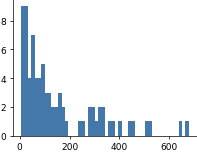

In [8]:
q = plt.hist(distance_metrics["speed_um_h"], bins=50)

In [9]:
distance_metrics["large_jump"] = distance_metrics["speed_um_h"] > 200

In [10]:
distance_metrics

offset  loi_total_distance  speed_um_h  large_jump
date     embryo                                                    
20211018 1           74            0.000000  154.552722       False
         3          304            0.000000   21.110923       False
         1          841           32.928316  122.329384       False
         2         1056            0.000000  363.021758        True
         2         1256           20.167875  103.786295       False
...                 ...                 ...         ...         ...
20220505 8         8423          235.911982  132.766588       False
         1        11459          266.963543  188.120940       False
         8        11633          354.295523   10.866958       False
         8        13769          360.743252         NaN       False
         1        13957          397.498573         NaN       False

[90 rows x 4 columns]

In [11]:
distance_metrics = distance_metrics.dropna().reset_index()

In [12]:
grp = distance_metrics.groupby(["date","embryo"])

In [15]:
grp.sum()["large_jump"] > 0

date      embryo
20211018  1          True
          2          True
          3          True
          4          True
          7         False
          8          True
20220203  3          True
20220505  1          True
          3         False
          7         False
          8          True
Name: large_jump, dtype: bool

In [16]:
period = 1/(grp.sum()["large_jump"]/(grp.max()["offset"]-grp.min()["offset"])*60).values

/tmp/ipykernel_33097/3623287903.py:1: RuntimeWarning: divide by zero encountered in true_divide
  period = 1/(grp.sum()["large_jump"]/(grp.max()["offset"]-grp.min()["offset"])*60).values


In [17]:
np.nanmean(period[np.isfinite(period)])

6.998923611111111e+01